<a href="https://colab.research.google.com/github/nikolpapad/HF/blob/main/Guidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Guidance ⚛

Using the fine tuned model: https://huggingface.co/johnowhitaker/sd-class-wikiart-from-bedrooms
from the Pretreined original:
https://huggingface.co/google/ddpm-bedroom-256



In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

Scheduler

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

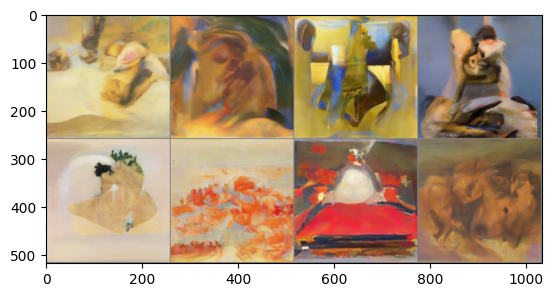

In [ ]:
# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [ ]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()  # Mean absolute difference between the image pixels and the target color
    return error

Modified version of the sampling loop where at each step:
- Create a new version of x that has *requires_grad = True*
- Calculates the denoised version (x0)
- Feeds the predicted x0 through the loss fcn
- Find gradient of loss fcn with respect to x
- Use this conditioning gradient to modify x before we step with the scheduler: Hopeing to push x in a direction that will lead to lower loss according to our guidance function

First Variant: we set requires_grad on x *after* we get our noise prediction from the Unet
1.   more memory efficient - since we don't have to trace gradients back through the diffusion model
2.   BUT less accurate gradient

Second variant we set requires grad on x before feeding it to the UNet and then calculate the predicted x0
1. Slower
2. More precise

0it [00:00, ?it/s]

0 loss: 30.08214569091797
10 loss: 12.406444549560547
20 loss: 11.51252269744873
30 loss: 11.588533401489258


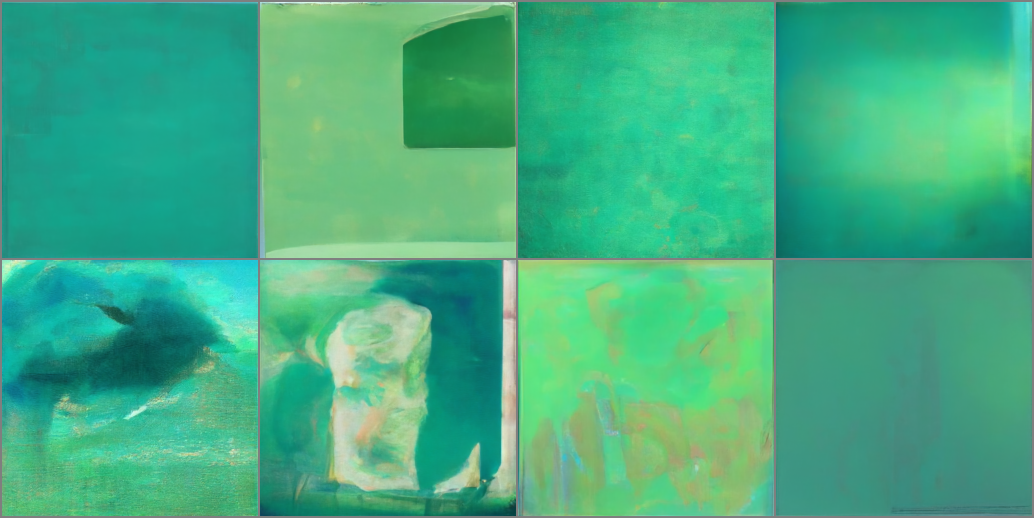

In [ ]:
# Variant 1: shortcut method

# The guidance scale determines the strength of the effect
guidance_loss_scale = 40  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

0it [00:00, ?it/s]

0 loss: 28.231582641601562
10 loss: 22.61859893798828
20 loss: 22.34142303466797
30 loss: 22.449338912963867


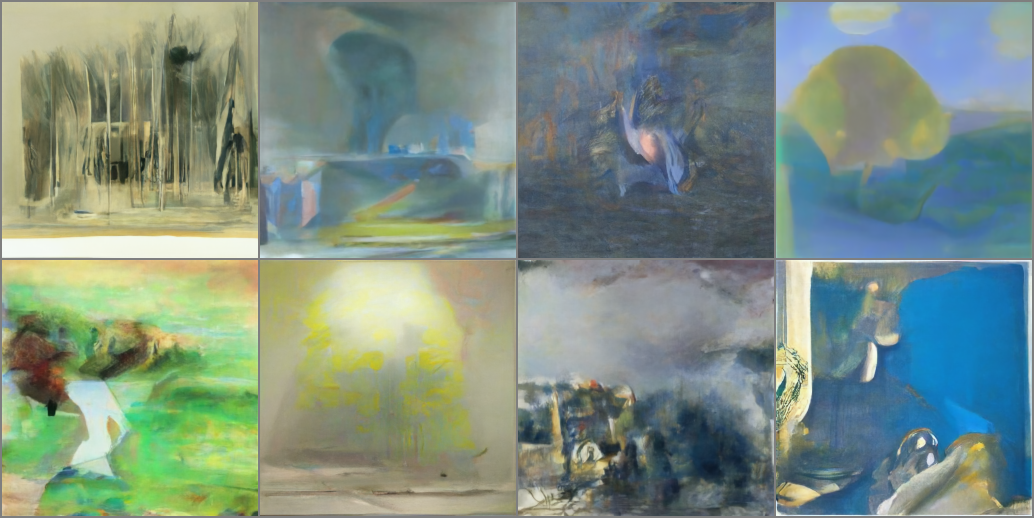

In [ ]:
# Variant 2: long way
guidance_loss_scale = 40
x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
  # Prepare model input
  x = x.detach().requires_grad_()
  model_input = scheduler.scale_model_input(x,t)

  noise_pred = image_pipe.unet(model_input, t)["sample"]

  # Get the predicted x0:
  x0 = scheduler.step(noise_pred, t, x).pred_original_sample

  # Loss
  loss = color_loss(x0) * guidance_loss_scale
  if i % 10 == 0:
    print(i, "loss:", loss.item())

  # Get gradient
  cond_grad = -torch.autograd.grad(loss, x)[0]
  x = x.detach() + cond_grad  # modify x based on this gradient

  x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow = 4)
im = grid.permute(1,2,0).cpu().clip(-1,1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

## CLIP Guidance

Use CLIP as a scoring machine, where high score = image matches the text.

CLIP is a model that can take:
- an image → turn it into a vector
- text → turn it into a vector

How?
1. Convert my text prompt into a CLIP embedding
2.

In [ ]:
pip install open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
import open_clip
from torchvision import transforms

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-L-14", pretrained="openai"
)
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(
            5
        ),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )  # Note: applies the above transforms

    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)

    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

open_clip_model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Continue as before with "Guidance as the clip loss"


/tmp/ipython-input-118833234.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


0it [00:00, ?it/s]

Step: 0 , Guidance loss: 9.95695972442627
Step: 25 , Guidance loss: 9.621524810791016


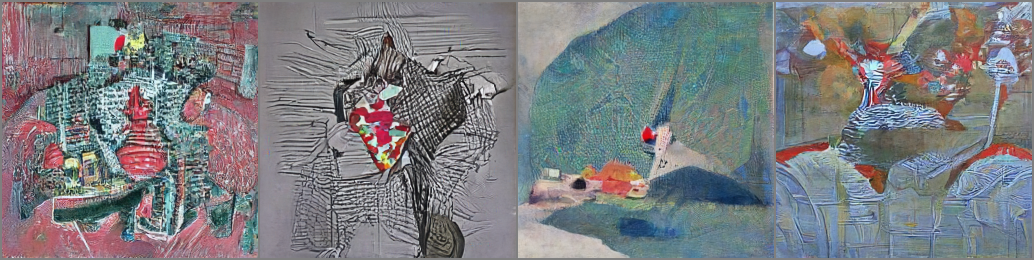

In [ ]:
#  applying guidance using CLIP

prompt = "Red dragon sitting in his room eatting pizza"  # param

# Explore changing this
guidance_scale = 10  #
n_cuts = 4  #

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(
    device
)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))